# PEL218 - Atividade 4
Processamento de Linguagem Narual (Prof. Guilherme Wachs)

Claudio Aparecido Borges Junior (RA 120122-7)

## Atividade 4

* Escolher qualquer base de dados para classificação de textos;
* Modelar Naive Bayes;
  * Siga o passo-a-passo de tratamento de texto de baixo nível;
  * Pode usar Regex;
  * Pode usar embeddings.
* Fazer uma melhoria no modelo;
* Medir resultados e comparar os 2 modelos;
* Cuidado com Plágios!

## Resposta

### Base de dados

Foi utilizada a base de dados `BBC Full Text Document Classification` ([link](shorturl.at/bBKOZ)) que contém 2225 documentos em inglês do website `BBC News` compreendendo 5 áreas distintas de 2004 até 2005, sendo elas: negócios, entretenimento, política, esportes e tecnologia. 

Fonte: D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006

In [1]:
import collections
import operator
import os
import pprint
import re

import matplotlib.pyplot as plt
import numpy as np

from scipy.sparse import lil_matrix, csr_matrix

In [2]:
# Create a full file paths' generator of all files downloaded for the classification
bbc_data_path = 'bbc_classification/bbc-fulltext (document classification)/bbc/'

# Create a a labeled file paths' list using the folder name as the label
# The first element is the file path and the second is the label
labeled_files = [(os.path.join(dir_name, file_name), dir_name.split('/')[-1])
                 for dir_name, _, file_names in os.walk(bbc_data_path)
                 for file_name in file_names if file_name != 'README.TXT']

 ### Funções auxiliares

In [3]:
def read_document(file):
    # Read a file and return its content
    with open(file, 'r', encoding='latin-1') as f:
        return f.read()

In [4]:
def split_title_text(content):
    # Split the document into text and title assuming the first line is the title
    splitted = content.split('\n')
    title = splitted[0]
    text = '\n'.join(splitted[1:])
    return title, text,

In [5]:
def tokenize(text):
    text = text.lower()
    text = re.sub('\n', ' ', text)
    text = re.sub('[,.+=]', ' ', text)
    text = re.sub('[0-9]', '', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    return text.split(' ')

### Análise da base de dados

A base de dados é dividida em 5 classes não balanceadas. Cada classe possuí uma quantidade específica de documentos conforme distribuição abaixo:

Text(0.5, 1.0, 'Distribuição dos documentos')

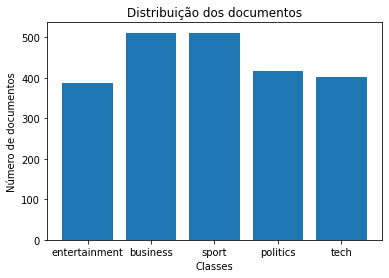

In [6]:
labels_counter = collections.Counter([label for _, label in labeled_files])
plt.bar(labels_counter.keys(), labels_counter.values())
plt.xlabel('Classes')
plt.ylabel('Número de documentos')
plt.title('Distribuição dos documentos')

Os documentos possuem título e texto, sendo que os títulos estão localizados na primeira linha de cada documento. Abaixo são apresentadas as distribuições de dos comprimentos dos títulos e dos textos:

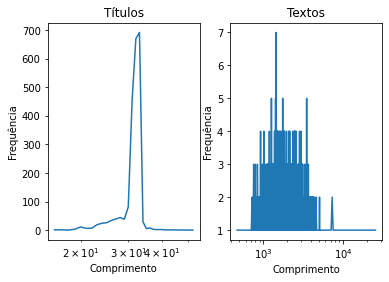

In [7]:
title_len_counter = collections.Counter()
text_len_counter = collections.Counter()
for file_name, label in labeled_files:
    doc = read_document(file_name)
    title, text = split_title_text(doc)
    title_len_counter[len(title)] += 1
    text_len_counter[len(text)] += 1
title_len_counter = collections.OrderedDict(sorted(title_len_counter.items()))
text_len_counter = collections.OrderedDict(sorted(text_len_counter.items()))

plt.subplots(1, 2)
plt.subplot(1, 2, 1)
plt.plot(title_len_counter.keys(), title_len_counter.values(), '-')
plt.title('Títulos')
plt.xlabel('Comprimento')
plt.ylabel('Frequência')
plt.xscale('log')

plt.subplot(1, 2, 2)
plt.plot(text_len_counter.keys(), text_len_counter.values(), '-')
plt.title('Textos')
plt.xlabel('Comprimento')
plt.ylabel('Frequência')
plt.xscale('log')

### Classificador bayesiano ingênuo

O classificador é do tipo bayesiano ingênuo que utiliza 2 métodos, o `train` e o `predict`. O primeiro treina e retorna um modelo bayesiano com a lista de rótulos, as probabilidades à priori de cada rótulo, as verossimilhanças de cada palavra de cada rótulo e o vocabulário utilizado. O treinamento utiliza a suavização laplaciana para cálculo da verossimilhança.

In [8]:
def train(labeled_docs):
    # Calculate the prior probability
    n_docs = len(labeled_docs)
    labels_counter = collections.Counter([label for _, label in labeled_docs])
    priors = {label: np.log(count / n_docs) for label, count in labels_counter.items()}

    # Create the vocabulary (unique words in all repository), and calculate the likelyhoods
    vocabulary = set()
    word_freq_per_label = collections.defaultdict(lambda: collections.Counter())
    words_per_label = collections.Counter()
    for doc, label in labeled_docs:
        for word in tokenize(doc):
            vocabulary.add(word)
            word_freq_per_label[label][word] += 1
            words_per_label[label] += 1
            
    # Likelyhood using laplacian smoothing
    likelyhoods = {
        label: {word: np.log((word_freq_per_label[label][word] + 1) / (words_per_label[label] + len(vocabulary)))
                for word in vocabulary}
        for label in word_freq_per_label}
    
    labels = priors.keys()
    
    return {'labels': labels, 'priors': priors, 'likelyhoods': likelyhoods, 'vocabulary': vocabulary}

In [9]:
def predict(model, doc):
    # Predict the class of a giving document
    predictions = {
        label: model['priors'][label] 
               + sum([model['likelyhoods'][label][word]
                      for word in tokenize(doc)
                      if word in model['vocabulary']])
        for label in model['labels']}
    
    return max(predictions.items(), key=operator.itemgetter(1))[0]

### Experimentação

Com a finalidade de realizar uma experimentação, métricas de avaliação como precisão e revocação são apresentadas abaixo como medidas de qualidade, assim como a validação cruzada para minimizar o viés dos dados.

In [10]:
def cross_validation(dataset, k=10):
    # Shuffle the documents
    np.random.shuffle(dataset)
    
    # Split the dataset into k-foldings of training and test
    ranges = np.linspace(0, len(dataset), num=(k + 1), dtype=int)
    groups = [dataset[ranges[i]:ranges[i + 1]]
              for i in range(len(ranges) - 1)]
    for i in range(k):
        train = np.concatenate(groups[:i] + groups[i + 1:])
        test = groups[i]
        yield train, test,

In [11]:
def experiment(setup, train_f=train, predict_f=predict):
    train_data = setup[0]
    test_data = setup[1]
    
    # Train the model with the train_data and test it with test_data
    model = train_f(train_data)
    labeled_predictions = [(predict_f(model, doc), label) for doc, label in test_data]
    return labeled_predictions, model

In [12]:
def score(labeled_predictions, model):
    # Create the confusion matrix
    labels = model['labels']
    n_labels = len(labels)
    labels_idx = {label: idx for idx, label in enumerate(model['labels'])}
    
    matrix = np.zeros((n_labels, n_labels))
    for prediction, actual in labeled_predictions:
        actual_idx = labels_idx[actual]
        prediction_idx = labels_idx[prediction]
        matrix[actual_idx][prediction_idx] += 1
    
    # Sum the matrix in both directions (row-wise and column-wise)
    matrix_sum_axis_0 = matrix.sum(axis=0)
    matrix_sum_axis_1 = matrix.sum(axis=1)

    
    f1_func = lambda precision, recall: (2 * precision * recall) / (precision + recall)

    score = {}
    # Calculate the score for each label
    for label in labels:
        idx = labels_idx[label]
        precision = matrix[idx][idx] / matrix_sum_axis_1[idx]
        recall = matrix[idx][idx] / matrix_sum_axis_0[idx]
        f1 = f1_func(precision, recall)
        score[label] = {
            'precision': precision,
            'recall': recall,
            'f1': f1
        }
    
    # Micro averaging
    micro_avg_precision = matrix.trace() / sum(matrix_sum_axis_1)
    micro_avg_recall = matrix.trace() / sum(matrix_sum_axis_0)
    micro_avg_f1 = f1_func(micro_avg_precision, micro_avg_recall)
    score['micro-avg'] = {
        'precision': micro_avg_precision,
        'recall': micro_avg_recall,
        'f1': micro_avg_f1
    }

    # Macro averaging
    macro_avg_precision = np.mean([score[label]['precision']
                                   for label in score.keys()])
    macro_avg_recall = np.mean([score[label]['recall']
                                for label in score.keys()])
    macro_avg_f1 = f1_func(macro_avg_precision, macro_avg_recall)
    score['macro-avg'] = {
        'precision': macro_avg_precision,
        'recall': macro_avg_recall,
        'f1': macro_avg_f1
    }
    
    # Return both score (per label, micro and macro) and the confusion matrix
    return score, matrix, labels_idx,

### Execução do experimento

Abaixo são apresentados os valores mínimo, máximo e médio da execução cruzada da base de dados:

In [13]:
def run_experiment_1():
    labeled_docs = [(read_document(file), label) for file, label in labeled_files]
    setups = cross_validation(labeled_docs, k=10)
    micro_f1 = []
    macro_f1 = []
    matrices = []
    for i, setup in enumerate(setups):
        labeled_predictions, model = experiment(setup)
        score_result, matrix, labels_idx = score(labeled_predictions, model)
        micro_f1.append(score_result['micro-avg']['f1'])
        macro_f1.append(score_result['macro-avg']['f1'])
        matrices.append(matrix)
    
    return micro_f1, macro_f1, matrices, labels_idx

In [58]:
micro_f1, macro_f1, matrices, labels_idx = run_experiment_1()
print('Experimento 1:')
print('\tMicro-averaging min={:.4f}, max={:.4f}, mean={:.4f}'.format(
    min(micro_f1), max(micro_f1), np.mean(micro_f1)))
print('\tMacro-averaging min={:.4f}, max={:.4f}, mean={:.4f}'.format(
    min(macro_f1), max(macro_f1), np.mean(macro_f1)))
print('\tMatrix de confusão (média) labels={} \n'.format(list(labels_idx.keys())), np.mean(matrices, axis=0))

Experimento 1:
	Micro-averaging min=0.9550, max=0.9865, mean=0.9730
	Macro-averaging min=0.9558, max=0.9867, mean=0.9725
	Matrix de confusão (média) labels=['politics', 'entertainment', 'tech', 'business', 'sport'] 
 [[40.8  0.   0.2  0.7  0. ]
 [ 0.6 38.5  1.1  0.1  0.1]
 [ 0.3  0.2 39.5  0.1  0. ]
 [ 1.2  0.   1.2 46.8  0. ]
 [ 0.1  0.   0.   0.1 50.9]]


A média micro foi ligeiramente superior a média macro, indicando que as classes com mais exemplos do que outras possuem uma medida F1 superior as outras classes.

### Melhoria no modelo
As melhorias propostas são:
1. Aprimoramento do `tokenizador` removendo caracteres especiais;
2. Remoção de stopwords durante o treinamento do modelo bayesiano ingênuo;
3. Utilização de TF-IDF como heurística;

In [15]:
def tokenize_v2(doc):
    it = re.finditer("[-a-zA-Z\xc0-\xff]+", doc, flags=re.MULTILINE | re.DOTALL)
    for word in it:
        yield word.group(0).lower()

In [16]:
def make_tf_idf(labeled_docs):
    labels = {label for _, label in labeled_docs}
    vocabulary = {word for doc, _ in labeled_docs for word in tokenize_v2(doc)}
    
    vocabulary_to_idx = {word: idx for idx, word in enumerate(vocabulary)}
    labels_to_idx = {label: idx for idx, label in enumerate(labels)}
    
    # Term frequency
    tf = np.ones((len(vocabulary), len(labels)))
    for doc, label in labeled_docs:
        for word in tokenize_v2(doc):
            tf[vocabulary_to_idx[word], labels_to_idx[label]] += 1
    # Inverse document frequency
    idf = len(labels) / (tf > 0).sum(axis=1)
    
    # Calculate the tf_idf
    tf_idf = np.zeros(tf.shape)
    for i in range(tf.shape[0]):
        for j in range(tf.shape[1]):
            tf_idf[i][j] = tf[i][j] * idf[i]
    
    # Normalize
    tf_idf_row_sum = tf_idf.sum(axis=1)
    for i in range(tf_idf.shape[0]):
        for j in range(tf_idf.shape[1]):
            tf_idf[i][j] = tf_idf[i][j] / tf_idf_row_sum[i]

    # Return the collection of values to be used by the model
    return tf_idf, vocabulary_to_idx, labels_to_idx,

In [17]:
def train_v2(labeled_docs):
    # Build up the stop words
    word_freq = collections.Counter([word for doc, _ in labeled_docs for word in tokenize_v2(doc)])
    stop_words = {word for word, _ in word_freq.most_common(200)}
    
    # Calculate the prior probability
    n_docs = len(labeled_docs)
    labels_counter = collections.Counter([label for _, label in labeled_docs])
    priors = {label: np.log(count / n_docs) for label, count in labels_counter.items()}

    # Create the vocabulary (unique words in all repository), and calculate the likelyhoods
    vocabulary = set()
    word_freq_per_label = collections.defaultdict(lambda: collections.Counter())
    words_per_label = collections.Counter()
    for doc, label in labeled_docs:
        for word in tokenize_v2(doc):
            if word in stop_words:
                # Ignore stop words
                continue
            vocabulary.add(word)
            word_freq_per_label[label][word] += 1
            words_per_label[label] += 1
            
    # Likelyhood using laplacian smoothing
    likelyhoods = {
        label: {word: np.log((word_freq_per_label[label][word] + 1) / (words_per_label[label] + len(vocabulary)))
                for word in vocabulary}
        for label in word_freq_per_label}
    
    labels = priors.keys()
    
    # Runs tf-idf
    tf_idf, vocabulary_to_idx, labels_to_idx = make_tf_idf(labeled_docs)
    
    return {
        'labels': labels,
        'priors': priors,
        'likelyhoods': likelyhoods,
        'vocabulary': vocabulary,
        'tf-idf': tf_idf,
        'vocabulary_to_idx': vocabulary_to_idx,
        'labels_to_idx': labels_to_idx
    }

In [55]:
def predict_v2(model, doc, alpha=0.90):
    labels = model['labels']
    vocabulary = model['vocabulary']

    # Prediction based on TF-IDF
    tf_idf = model['tf-idf']
    vocabulary_to_idx = model['vocabulary_to_idx']
    labels_to_idx = model['labels_to_idx']
    tf_idf_predictions = {
        label: sum([np.log(tf_idf[vocabulary_to_idx[word], labels_to_idx[label]])
                    for word in tokenize_v2(doc) if word in vocabulary])
        for label in labels
    }
        
    # Predict the class of a giving document
    priors = model['priors']
    likelyhoods = model['likelyhoods']
    predictions = {
        label: priors[label] 
               + sum([likelyhoods[label][word]
                      for word in tokenize_v2(doc)
                      if word in vocabulary])
        for label in labels}
    
    # Ensemble both methods
    ensemble = {
        label: alpha * predictions[label] + (1 - alpha) * tf_idf_predictions[label]
        for label in labels 
    }
        
    return max(ensemble.items(), key=operator.itemgetter(1))[0]

In [56]:
def run_experiment_2():
    labeled_docs = [(read_document(file), label) for file, label in labeled_files]
    setups = cross_validation(labeled_docs, k=10)
    micro_f1 = []
    macro_f1 = []
    matrices = []
    for i, setup in enumerate(setups):
        labeled_predictions, model = experiment(setup, train_f=train_v2, predict_f=predict_v2)
        score_result, matrix, labels_idx = score(labeled_predictions, model)
        micro_f1.append(score_result['micro-avg']['f1'])
        macro_f1.append(score_result['macro-avg']['f1'])
        matrices.append(matrix)
    
    return micro_f1, macro_f1, matrices, labels_idx

In [57]:
micro_f1, macro_f1, matrices, labels_idx = run_experiment_2()
print('Experimento 2:')
print('\tMicro-averaging min={:.4f}, max={:.4f}, mean={:.4f}'.format(
    min(micro_f1), max(micro_f1), np.mean(micro_f1)))
print('\tMacro-averaging min={:.4f}, max={:.4f}, mean={:.4f}'.format(
    min(macro_f1), max(macro_f1), np.mean(macro_f1)))
print('\tMatrix de confusão (média) labels={} \n'.format(list(labels_idx.keys())), np.mean(matrices, axis=0))

Experimento 2:
	Micro-averaging min=0.9640, max=0.9910, mean=0.9757
	Macro-averaging min=0.9646, max=0.9914, mean=0.9757
	Matrix de confusão (média) labels=['sport', 'business', 'entertainment', 'politics', 'tech'] 
 [[50.6  0.1  0.   0.3  0. ]
 [ 0.  49.   0.1  1.2  0.8]
 [ 0.   0.  36.4  0.3  0.7]
 [ 0.   0.5  0.1 40.8  0.2]
 [ 0.1  0.1  0.6  0.3 40.3]]


## Análise

O primeiro experimento utilizou o modelo bayesiano ingênuo sem remoção de $stopwords$ e um $tokenizador$ mais relaxado atingindo uma medida F1 média micro de 0.9730 e macro de 0.9725.

No segundo experimento o $tokenizador$ utilizado foi mais restritivo e as 200 palavras mais presentes foram assumidas como sendo $stopwords$ e foram removidas do modelo bayesiano ingênio. Além disso, foi criada uma tabela `tf-idf` sendo que foram utilizadas as categorias como documentos, ou seja, todos os documentos de uma mesma categoria foram agrupados produzindo assim o mesmo número de documentos quanto os números de categorias. Assim, a função de predição cálcula a probabilidade de cada categoria com base na tabela `tf-idf` e pondera seu resultado com a saída do classificador bayesiano utilizando um hiper-parâmetro alfa. O segundo experimento produziu uma medida F1 média micro de 0.9757 e macro de 0.9757.

Devido a alteração de 3 métodos simultaneamente não é possível saber quais deles realmente contribuiram para a diferença de medida F1 sem que se faça uma análise de cada alteração, porém pode-se entender que para 1 execução nas condições acima citadas, o experimento 2 obteve uma medida D1 superior ao experimento 1.

In [62]:
def bootstrapping(b_times=10):
    e1_micro_f1, e1_macro_f1, e1_matrices, e1_labels_idx = run_experiment_1()
    e2_micro_f1, e2_macro_f1, e2_matrices, e2_labels_idx = run_experiment_2()
    
    sigma = np.mean(e2_micro_f1) - np.mean(e1_micro_f1)
    n_better = 0
    for i in range(b_times):
        e1_micro_f1, e1_macro_f1, e1_matrices, e1_labels_idx = run_experiment_1()
        e2_micro_f1, e2_macro_f1, e2_matrices, e2_labels_idx = run_experiment_2()
        
        sigma_2 = np.mean(e2_micro_f1) - np.mean(e1_micro_f1)
        # Use 1 sigma instead of 2 sigmas
        if sigma_2 > sigma:
            n_better += 1
    
    return n_better / b_times

In [63]:
print("Bootstrapping", bootstrapping())

Bootstrapping 0.7


Uma análise de significância com hipótese nula $H_0$ de que o experimento 2 é melhor do que o o experimento 1 por coincidência de amostragem foi realizada através da função `bootstrapping`.